In [2]:
import sys
sys.path.append("../../")
from simulation_classes.drones import Drones
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

続いてドローンの初期化を行う。
複数台の巡行をシミュレートする。

N: ドローン台数

In [14]:
N = 3
T = 30
delta_t = 0.1
d_0 = Drones(2,0,1,1,1)
d_1 = Drones(1,0,0,1,1)
d_2 = Drones(0,0,0,1,1)

drone_list = [d_0,d_1,d_2]

for i in range(T):
  for idx,drone_i in enumerate(drone_list):
    if idx == 0:
      leader = drone_list[idx]
      leader.leader_update(delta_t)
      leader.record()
    else:
      follower = drone_list[idx]
      delta_x = drone_list[idx-1].xcor - follower.xcor
      follower.update(delta_t,delta_x )
      follower.record()


In [18]:
t = np.linspace(0,delta_t*(T+1), T+1)
print(len(t), len(d_0.xcorList))

31 31


(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 [Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0'),
  Text(2.5, 0, '2.5'),
  Text(3.0, 0, '3.0'),
  Text(3.5, 0, '3.5')])

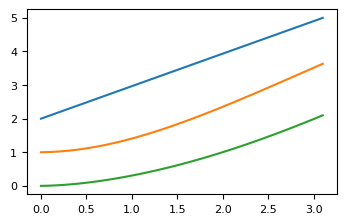

In [20]:


plt.figure(figsize=(4,2.4))
for drone in drone_list:
    plt.plot(t,np.array(drone.xcorList))
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)